# Setup and Data Loading

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
%cd '/gdrive/MyDrive/ML_for_SS'

/gdrive/MyDrive/ML_for_SS


## Utility Functions

In [152]:
'''Custom function to print information about Dataframe Columns '''

def column_info(dataframe, data_type, columns=None):
    # Filter columns by data type
    if columns is not None:
        relevant_columns = columns
    else:
        relevant_columns = dataframe.select_dtypes(include=data_type).columns

    # Filter DataFrame by relevant columns
    relevant_data = dataframe[relevant_columns]

    # Describe relevant columns
    if data_type == np.number:
        description = relevant_data.describe(include=data_type, percentiles=[]).loc[['count', 'mean', 'std', 'min', 'max']].T
        # Add column with total unique values
        description['unique'] = relevant_data.nunique()
        return description
    else:
        description = relevant_data.describe(include=data_type)
        return description.T


'''Function for Visualization / Plotting'''

def plot_func(dataframe, column_name = None):
    columns = []
    if column_name == None: # If no specific column is passed then display graph for all columns
        columns = dataframe.columns[:-1]
    else:
        columns.extend(column_name)

    for feature in columns:
        if df[feature].dtype == 'object':
            fig, axes = plt.subplots(1, 2, figsize=(7, 3))
            value_counts = df[feature].value_counts()
            colors = ['#ff6666','#00ced1','#b4eeb4', '#088da5']
            axes[0].pie(x=value_counts, labels=value_counts.index, autopct='%1.2f%%', colors=colors)
            axes[0].set_title('Pie Chart for {}'.format(feature))
            axes[1] = sns.countplot(x=df[feature], hue=df['Churn'], palette='Set2', saturation=1)
            axes[1].set_title('Countplot for {}'.format(feature))
            if len(value_counts)>=3: # To make it look more presentable rotating x-axis labels if there are more than 4 unique values
                axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
            plt.subplots_adjust(wspace=0.7)
            plt.show()
        else:
            plt.figure(figsize=(14, 3))
            plt.subplot(1,3,1)
            sns.histplot(x=df[feature])
            plt.title(f'Hist Plot - {feature}')
            plt.subplot(1,3,2)
            sns.kdeplot(data=df, x=feature, hue='Churn', fill=True)
            plt.xlabel(feature)
            plt.ylabel('Density')
            plt.subplots_adjust(wspace=0.35)
            plt.subplot(1,3,3)
            sns.boxplot(x = feature, y='Churn', data = dataframe)
            plt.title(f'Box Plot - {feature}')
            plt.show()

'''Function for evaluation the final results on test data'''

def eval_func(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    print('Results on Test Data:\n')
    print('Confusion matrix:')

    plt.figure(figsize=(4, 3))
    # Define class labels
    labels = ['Non-Churn', 'Churn']
    # Create heatmap
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')

    # Display the plot
    plt.show()

    # Calculate the scores
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    # Print the scores with 2 decimal places
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'F1-score: {f1:.2f}%')

''' Function to create dataframe from dictionary of scores after cross validation'''

def create_df(scores):
    # Create an empty list to store the data
    data = []

    # Iterate over the dictionary and extract the data
    for classifier, metrics in scores.items():
        accuracy = metrics['test_accuracy'].mean()
        precision = metrics['test_precision'].mean()
        recall = metrics['test_recall'].mean()
        f1_score = metrics['test_f1_score'].mean()
        data.append([classifier, accuracy, precision, recall, f1_score])

    # Create a DataFrame from the data list
    scores_df = pd.DataFrame(data, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    return scores_df

''' Function to plot the dataframe containing scores '''

def plot_df(scores_df):
    # Create a figure and axes with the desired size
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot the metrics
    scores_df.plot(x='Classifier', y=['Accuracy', 'Precision', 'Recall', 'F1-score'], kind='bar', ax=ax, rot=0)

    # Set the plot title and axis labels
    ax.set_title('Classifier Metrics')
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Score')

    # Show the plot
    plt.show()

## Data Loading

In [132]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(n=3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


# Exploratory Data Analysis

## Summary Stats and Pre-Processing

In [133]:
# Drop Customer ID as it is unique for each instance and does not provide any useful information.
# If we create a decision tree it can cause the model to start making prediction based on customer ID which will give 100% accurate results on training data but will be useless on test data
if 'customerID' in df.columns:
    df = df.drop(['customerID'], axis=1)
df= df.drop_duplicates()
print(f'Total Instances: {df.shape[0]}')
print(f'Total Features: {df.shape[1]-1}')


Total Instances: 7021
Total Features: 19


### Updating Columns

In [134]:
print(column_info(df, np.number))

#Note that SeniorCitizen has only 2 Unique values which means it is a binary categorical variable but is stored as int.
# Instead of integer, categorical value for SeniorCitizen will make more sense for visualization purposes
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object').replace({1: 'Yes', 0: 'No'})

                 count       mean        std    min     max  unique
SeniorCitizen   7021.0   0.162512   0.368947   0.00    1.00       2
tenure          7021.0  32.469449  24.534965   0.00   72.00      73
MonthlyCharges  7021.0  64.851894  30.069001  18.25  118.75    1585


In [135]:
print(column_info(df, object))
# In this case TotalCharges has over 6000 unique (floating point) values but they are stored as string.
# Change type to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Convert to numeric value without raising error

                 count unique               top  freq
gender            7021      2              Male  3541
SeniorCitizen     7021      2                No  5880
Partner           7021      2                No  3619
Dependents        7021      2                No  4911
PhoneService      7021      2               Yes  6339
MultipleLines     7021      3                No  3368
InternetService   7021      3       Fiber optic  3090
OnlineSecurity    7021      3                No  3490
OnlineBackup      7021      3                No  3080
DeviceProtection  7021      3                No  3087
TechSupport       7021      3                No  3465
StreamingTV       7021      3                No  2802
StreamingMovies   7021      3                No  2777
Contract          7021      3    Month-to-month  3853
PaperlessBilling  7021      2               Yes  4161
PaymentMethod     7021      4  Electronic check  2359
TotalCharges      7021   6531                      11
Churn             7021      

In [136]:
print(column_info(df, object, ['SeniorCitizen']), '\n')
print(column_info(df, np.number, ['TotalCharges']))

              count unique top  freq
SeniorCitizen  7021      2  No  5880 

               count         mean          std   min     max  unique
TotalCharges  7010.0  2290.353388  2266.820832  18.8  8684.8    6530


### Handling Missing Values

In [137]:
# Now that all types are correct, we take care of missing values
# df.dropna()
print(f'Total Missing Values Before:{df.isna().sum().sum()}')
# Go over each column and if column type is number then fill the missing value
for col in df.select_dtypes(include=np.number):
    df[col].fillna(df[col].median(), inplace = True)
# If column type is object then we just drop the values
for col in df.select_dtypes(include=object):
    df.drop([col], axis=1)
print(f'Total Missing Values After:{df.isna().sum().sum()}')

# The 11 missing values were from Total Charges column that had 11 times empty string repeated as can be seen from describe command above

Total Missing Values Before:11
Total Missing Values After:0


## Data Visualization

### Dependent/Response Variable

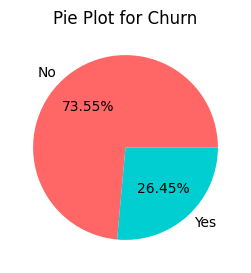

In [138]:
value_counts = df['Churn'].value_counts()
plt.figure(figsize=(6, 3))
colors = ['#ff6666','#00ced1','#b4eeb4', '#088da5']
plt.pie(x=value_counts, labels=value_counts.index, autopct='%1.2f%%', colors=colors)
plt.title('Pie Plot for Churn')
plt.show()


### Independent/Predicting Variables

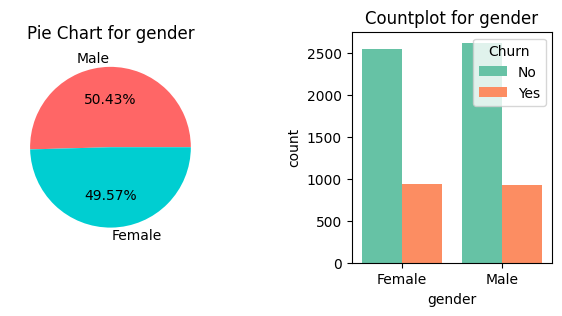

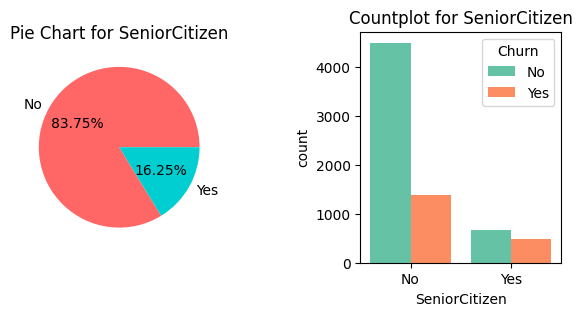

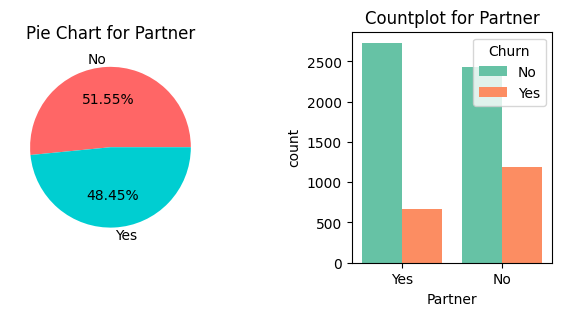

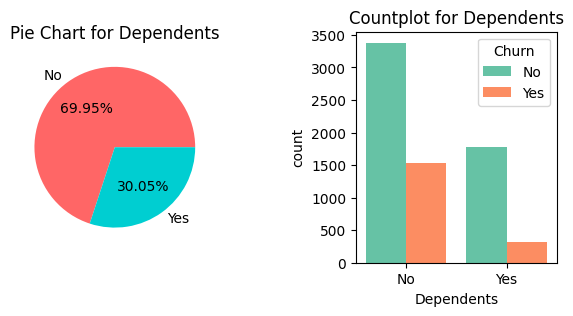

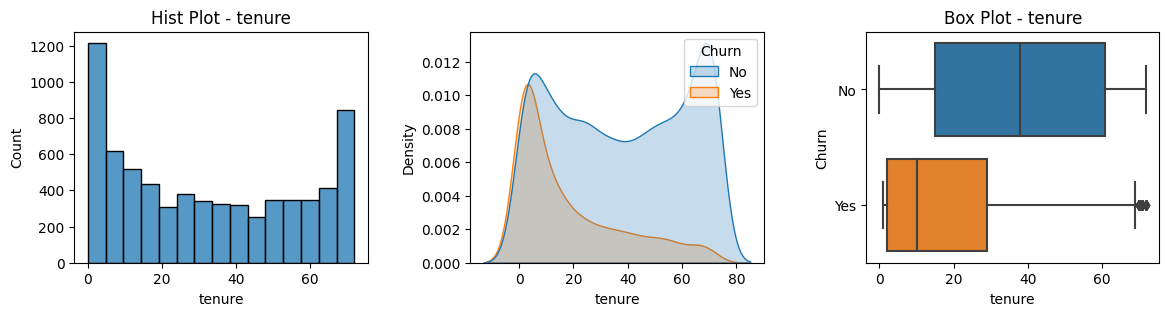

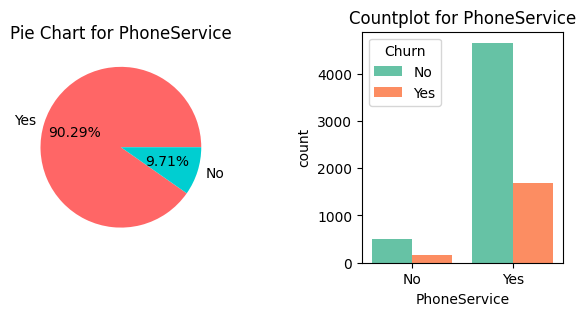

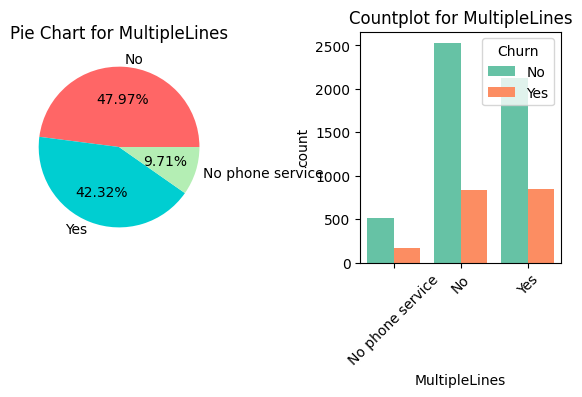

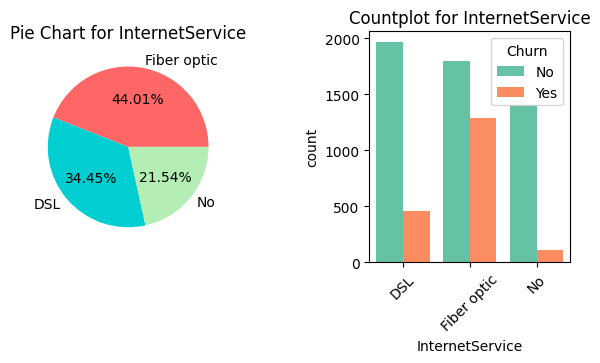

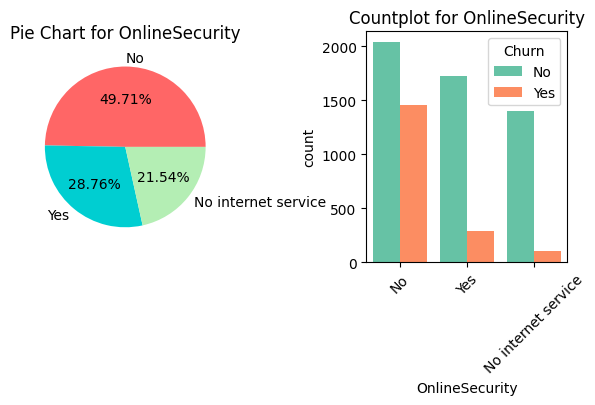

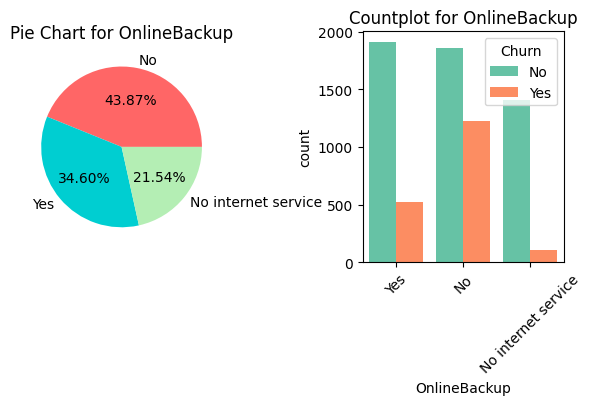

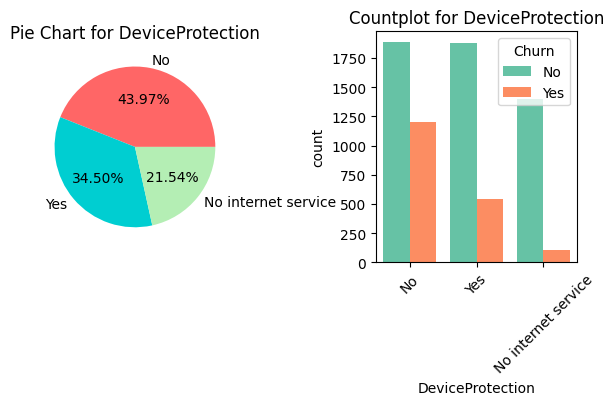

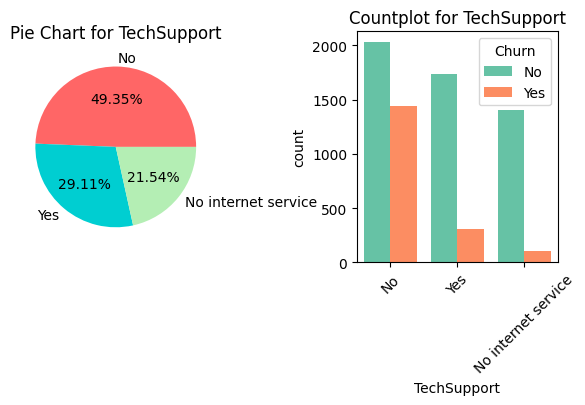

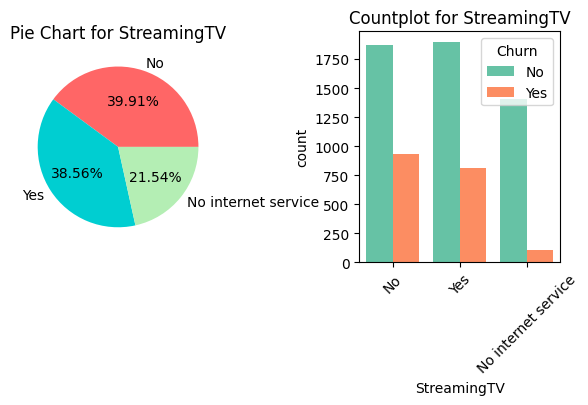

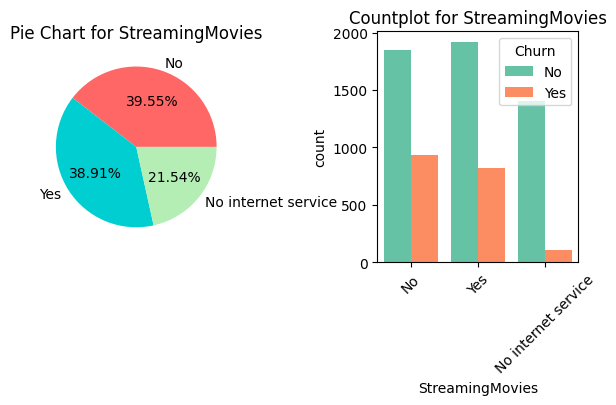

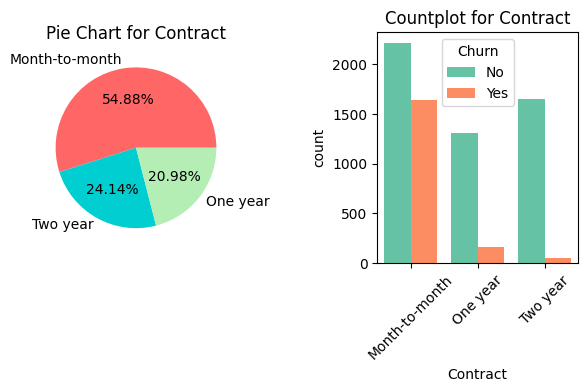

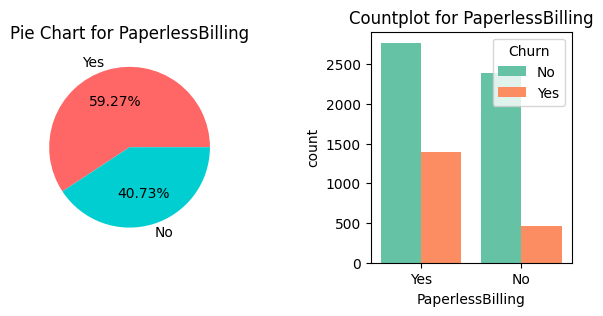

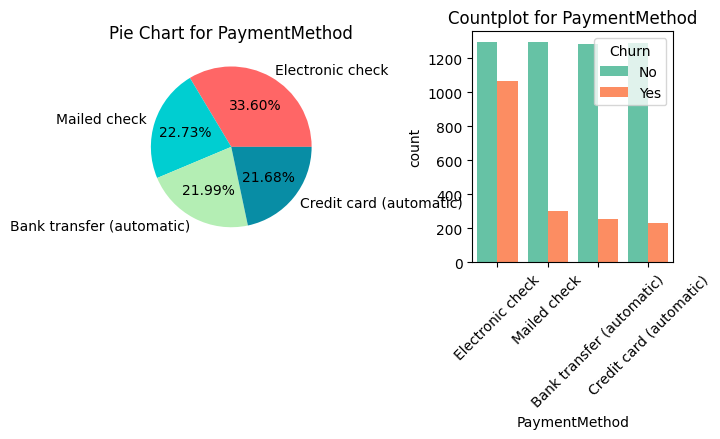

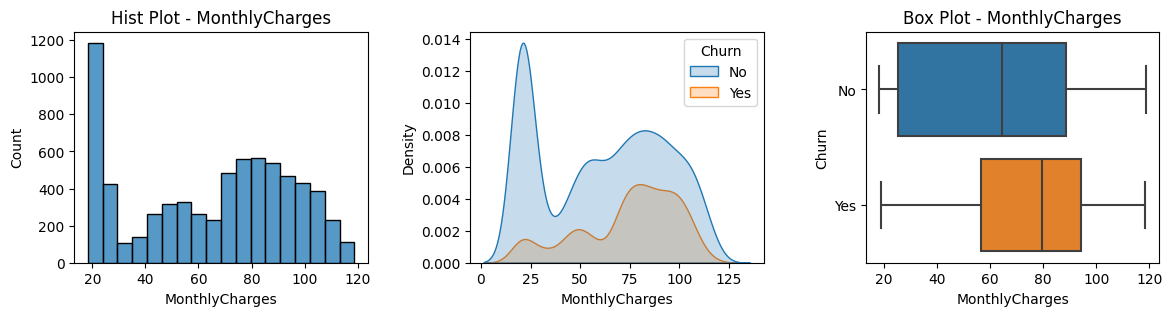

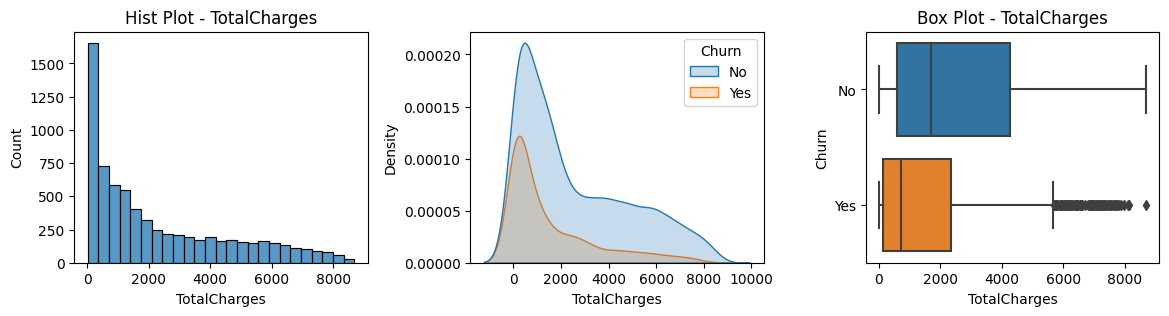

In [153]:
plot_func(df)

### Correlation

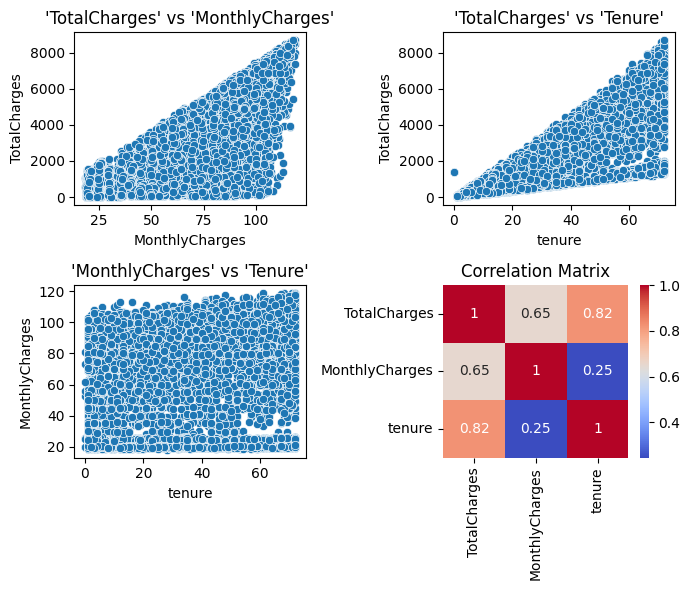

In [156]:
# Creating Plots of Continuous Variables against Churn

fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Plot 1: 'TotalCharges' vs 'MonthlyCharges'
sns.scatterplot(y='TotalCharges', x='MonthlyCharges', data=df, ax=axes[0, 0])
axes[0, 0].set_title("'TotalCharges' vs 'MonthlyCharges'")

# Plot 2: 'TotalCharges' vs 'Tenure'
sns.scatterplot(y='TotalCharges', x='tenure', data=df, ax=axes[0, 1])
axes[0, 1].set_title("'TotalCharges' vs 'Tenure'")

# Plot 3: 'MonthlyCharges' vs 'Tenure'
sns.scatterplot(y='MonthlyCharges', x='tenure', data=df, ax=axes[1, 0])
axes[1, 0].set_title("'MonthlyCharges' vs 'Tenure'")

# Plot 4: Correlation matrix heatmap
correlation_matrix = df[['TotalCharges', 'MonthlyCharges', 'tenure']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title("Correlation Matrix")

plt.tight_layout()
plt.show()


## Feature Engineering

In [157]:
category_ranges = [0, 12, 36, 73]
category_labels = ['New', 'Regular', 'Long-Term']

# Creating new categorical columns
df['tenure_cat'] = pd.cut(df['tenure'], bins=category_ranges, labels=category_labels, right=False).astype('object')
df['SafeGuard'] = ((df['OnlineSecurity'] != 'No') & (df['DeviceProtection'] != 'No')).astype('int').astype('object')
df[['tenure','tenure_cat','OnlineSecurity','DeviceProtection', 'SafeGuard']].head()

,tenure,tenure_cat,OnlineSecurity,DeviceProtection,SafeGuard
0,1,New,No,No,0
1,34,Regular,Yes,Yes,1
2,2,New,Yes,No,0
3,45,Long-Term,Yes,Yes,1
4,2,New,No,No,0


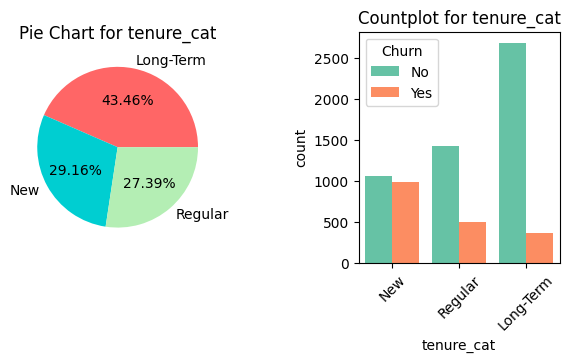

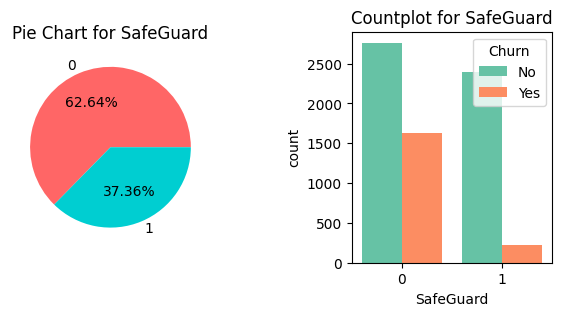

In [158]:
plot_func(df, ['tenure_cat', 'SafeGuard'])
plt.show()

In [77]:
# We can drop tenure as we have created a categorical version that captures the same information
if 'tenure' in df.columns:
    df.drop('tenure', axis=1, inplace=True)

## Encoding and *Standardization*

In [78]:
def scaling_func(df):
    columns_to_scale = ['MonthlyCharges', 'TotalCharges']  # Specify the columns to be scaled
    scaler = StandardScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

def encoder_func(df):
    # Categorical columns
    cat_cols = df.select_dtypes(include="object").columns.tolist()

    # Binary columns with 2 values
    bin_cols = df[cat_cols].nunique()[df[cat_cols].nunique() == 2].index.tolist()

    # Label encode binary columns
    le = LabelEncoder()
    df[bin_cols] = df[bin_cols].apply(lambda x: le.fit_transform(x))

    # Perform one-hot encoding for multi-value columns
    df = pd.get_dummies(df, columns=list(set(cat_cols) - set(bin_cols)))
    return df

#### After Encoding

In [79]:
df = encoder_func(df)
df.head(n=3)

# We can see that after creating dummy variables we have 44 columns

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SafeGuard,...,Contract_Two year,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,0,1,29.85,29.85,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1,0,0,0,1,0,56.95,1889.50,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,53.85,108.15,1,0,...,0,1,0,0,1,0,0,1,0,0


In [80]:
# Filter and drop columns ending with '_No internet service' or '_No phone service'
# This is because we already have separate columns of InternetService and PhoneService.
# So these columns will have -1 correlation with them and hence do not provide any useful information
cols_to_drop = df.filter(regex='_No internet service$|_No phone service$').columns
df.drop(cols_to_drop, axis=1, inplace=True)

In [81]:
x = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()
# Splitting the original dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify =y)
# Scaling/Standardization
x_train = scaling_func(x_train)
x_test = scaling_func(x_test)

#### After Standardization

In [130]:
x_train.head(n=3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SafeGuard,tenure_cat_Long-Term,...,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
2629,1,0,0,0,1,0,0.193165,-0.946357,0,0,...,0,1,0,0,1,0,1,0,1,0
2650,0,0,0,0,1,1,0.647355,-0.435351,1,0,...,0,1,0,0,1,0,1,0,0,1
1418,1,0,1,1,1,1,0.820380,1.794546,0,1,...,0,1,0,0,1,0,0,1,0,1


# Machine Learning

## With Unbalanced Data

### Training

In [83]:
# Perform cross-validation and get the scores for each metric

def all_models(x_train, y_train, scoring, k=10):
    # Initialize the models
    random_forest = RandomForestClassifier()
    boosting = AdaBoostClassifier() # Base estimator is Decision Tree
    sgd_classifier = SGDClassifier()
    logistic_regression = LogisticRegression(max_iter=1000)
    knn = KNeighborsClassifier()
    mlp = MLPClassifier(hidden_layer_sizes=(16, 8, 4), activation='relu', learning_rate='adaptive', max_iter=1000)

    random_forest_scores = cross_validate(random_forest, x_train, y_train, cv=k, scoring=scoring)
    boosting_scores = cross_validate(boosting, x_train, y_train, cv=k, scoring=scoring)
    sgd_classifier_scores = cross_validate(sgd_classifier, x_train, y_train, cv=k, scoring=scoring)
    logistic_regression_scores = cross_validate(logistic_regression, x_train, y_train, cv=k, scoring=scoring)
    knn_scores = cross_validate(knn, x_train, y_train, cv=k, scoring=scoring)
    mlp_scores = cross_validate(mlp, x_train, y_train, cv=k, scoring=scoring)

    # Store the scores in a dictionary
    scores = {
        'Random Forest': random_forest_scores,
        'Boosting': boosting_scores,
        'SGD Classifier': sgd_classifier_scores,
        'Logistic Regression': logistic_regression_scores,
        'KNN': knn_scores,
        'MLP': mlp_scores
    }

    return scores

In [84]:
# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

scores = all_models(x_train, y_train, scoring)

In [85]:
scores_df = create_df(scores)
scores_df

,Classifier,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.785789,0.620781,0.490863,0.546486
1,Boosting,0.801993,0.656460,0.529276,0.584878
2,SGD Classifier,0.782936,0.641883,0.469254,0.510216
3,Logistic Regression,0.802168,0.665011,0.507677,0.574167
4,KNN,0.773149,0.578392,0.523857,0.549098
5,MLP,0.783474,0.605968,0.523884,0.559755


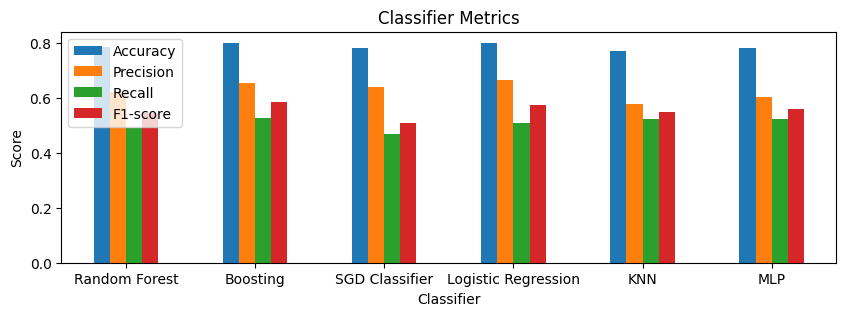

In [86]:
plot_df(scores_df)

### Hyper-Parameter Tuning

In [87]:
def boost_hp_tuning(x_train, y_train):
    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [25, 30, 35, 40, 45, 50],
        'learning_rate': [1, 0.1, 0.01]
    }

    boosting = AdaBoostClassifier()
    grid_search = GridSearchCV(boosting, param_grid, cv=10, scoring= 'f1')
    grid_search.fit(x_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

In [88]:
boost_hp_tuning(x_train, y_train)

Best Parameters: {'learning_rate': 1, 'n_estimators': 25}
Best Score: 0.5871375211285652


### Evaluation

Results on Test Data:

Confusion matrix:


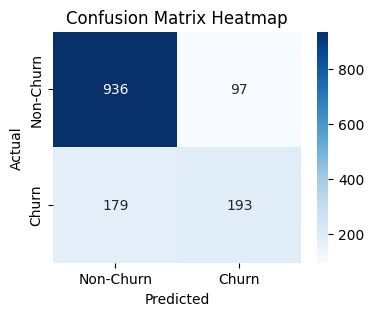

Accuracy: 80.36%
Precision: 66.55%
Recall: 51.88%
F1-score: 58.31%


In [89]:
boosting = AdaBoostClassifier(n_estimators =25) # Base estimator is Decision Tree
boosting.fit(x_train, y_train)
eval_func(boosting, x_test, y_test)

## With Balanced Data

### Balancing

In [90]:
# Split the data based on class label
class_0 = df[df['Churn'] == 0]
class_1 = df[df['Churn'] == 1]

# Sample a subset of class 0 instances matching the number of class 1 instances
class_0 = class_0.sample(n=len(class_1), random_state=42)

# Concatenate class 1 data and sampled class 0 data to create the final balanced subset
df_new = pd.concat([class_1, class_0])


In [91]:
df_new['Churn'].value_counts()

1    1857
0    1857
Name: Churn, dtype: int64

In [92]:
x_new = df_new.drop('Churn', axis=1).copy()
y_new = df_new['Churn'].copy()
# Splitting the original dataset into train and test sets
x_tr_new, x_te_new, y_tr_new, y_te_new = train_test_split(x_new, y_new, test_size=0.2, random_state=42, stratify =y_new)

x_tr_new = scaling_func(x_tr_new)
x_te_new = scaling_func(x_te_new)

### Training

In [93]:
scores_new = all_models(x_tr_new, y_tr_new, scoring)

In [94]:
scores_df_new = create_df(scores_new)
scores_df_new

,Classifier,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.744875,0.738234,0.760416,0.748942
1,Boosting,0.769112,0.751214,0.805501,0.777200
2,SGD Classifier,0.731755,0.737864,0.748894,0.729846
3,Logistic Regression,0.765407,0.751537,0.793393,0.771707
4,KNN,0.732085,0.708841,0.789348,0.746779
5,MLP,0.721973,0.711360,0.749633,0.729525


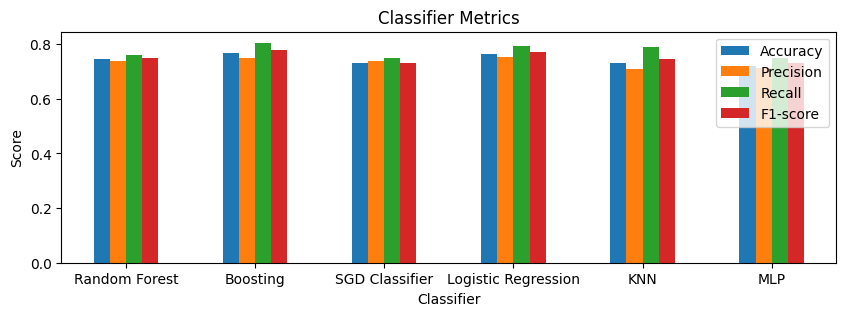

In [95]:
plot_df(scores_df_new)

### Hyper-Parameter Tuning

In [96]:
boost_hp_tuning(x_tr_new, y_tr_new)

Best Parameters: {'learning_rate': 1, 'n_estimators': 25}
Best Score: 0.7792518236233705


### Evaluation

Results on Test Data:

Confusion matrix:


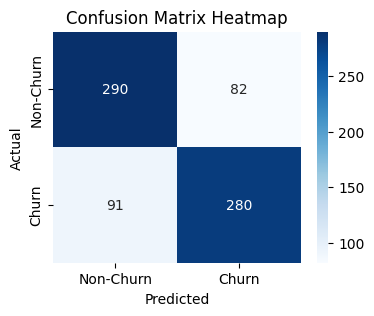

Accuracy: 76.72%
Precision: 77.35%
Recall: 75.47%
F1-score: 76.40%


In [98]:
boosting = AdaBoostClassifier(n_estimators = 25) # Base estimator is Decision Tree
boosting.fit(x_tr_new, y_tr_new)
eval_func(boosting, x_te_new, y_te_new)

### Feature Importance

Top 5 Features:
TotalCharges: 0.24
MonthlyCharges: 0.12
tenure_cat_New: 0.08
Contract_Month-to-month: 0.08
PaperlessBilling: 0.04



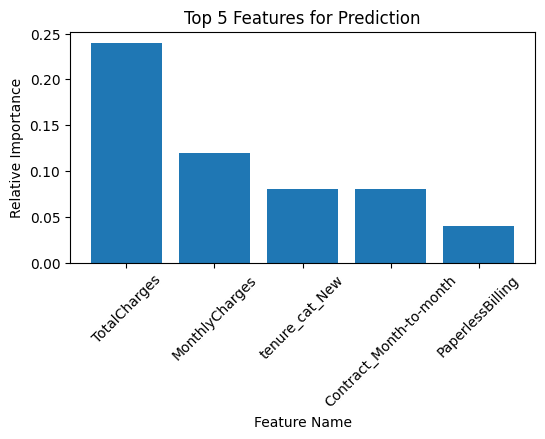

In [116]:
# Retrieve feature importances and sort them
importances = boosting.feature_importances_
feature_names = x_tr_new.columns
indices = np.argsort(importances)[::-1]

# Print Top 5 Features
feature_names = feature_names[indices[:5]]
importances = importances[indices[:5]]
print("Top 5 Features:")
for feature_name, importance in zip(feature_names, importances):
    print(f"{feature_name}: {importance}")
print()

# Visualization
plt.figure(figsize=(6, 3))
plt.title("Top 5 Features for Prediction")
plt.bar(range(5), importances)
plt.xticks(range(5), feature_names, rotation=45)
plt.xlabel("Feature Name")
plt.ylabel("Relative Importance")
plt.show()